# **Использование различных оптимизаторов для минимизации весов нейронных сетей на основе набора данных MNIST**

MNIST - является классических набором данных для задачи распознавания рукописных цифр.

Ваш ИСУ id и ФИО:

409682 Тимошкин Роман Вячеславович

**Задание:**
1. Обучить и измерить точность нейросетей с различными предложенными оптимизаторами из библиотеки PyTorch
2. Построить графики длительности обучения, точности результатов, загрузки CPU и использования оперативной памяти.
3. Сделать анализ полученных результатов. (разде 9)
4. Добавить собственные оптимизаторы из коллекции библиотеки Pytorch.
5. Повторить шаги 2-3.
6. *Можно попробовать оптимизаторы из других библиотек, но не все они могут быть совместимы с Pytorch архитектурой (см. раздел 10).

Так как нейронные сети могут обучаться достаточно долго, то запускать их можно по одной, чтобы не потерять результаты.

По указаной же выше причине, можно сначала поставить нейронные сети тренироваться, а в это время заняться изучением теоретической шпаргалки в разделе 1.

В разделе 9, секцию А можно заполнять, пока нейронные сети ещё учатся.

In [3]:
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### **Советы для студентов**
1. Для методов второго порядка (например, Ньютона) уменьшайте размерность данных (например, используйте `28x28 → 14x14`), чтобы гессиан не занимал слишком много памяти.
2. Экспериментируйте с `batch_size` для баланса между памятью и скоростью.
3. Используйте `torch.jit` для оптимизации вычислений.

#### **1. Теоретическая шпаргалка**
### **1. Основы методов оптимизации**
#### **1.1 Градиентный спуск и его модификации**
- **Формула обновления параметров**:  
  $ \theta_{t+1} = \theta_t - \eta \nabla L(\theta_t) $,  
  где $ \eta $ — learning rate, $ \nabla L $ — градиент функции потерь.
- **Стохастический градиентный спуск (SGD)**:  
  Использование подвыборки (батча) для оценки градиента.  
  Плюсы: низкая вычислительная стоимость.  
  Минусы: шум, медленная сходимость.
- **Метод моментов**:  
  $ v_{t+1} = \beta v_t + (1-\beta) \nabla L(\theta_t) $,  
  $ \theta_{t+1} = \theta_t - \eta v_{t+1} $.  
  Идея: инерция для подавления шума.

#### **1.2 Методы второго порядка**
- **Метод Ньютона**:  
  $ \theta_{t+1} = \theta_t - H^{-1}(\theta_t) \nabla L(\theta_t) $,  
  где $ H $ — гессиан.  
  Проблемы: вычисление $ H^{-1} $ для больших моделей ($ O(n^3) $).
- **Квазиньютоновские методы (L-BFGS)**:  
  Аппроксимация гессиана с помощью истории градиентов.  
  Преимущества: меньше памяти, чем у полного BFGS.

#### **1.3 Адаптивные методы**
- **RMSProp**:  
  Адаптивный шаг на основе скользящего среднего квадратов градиентов:  
  $ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma) g_t^2 $,  
  $ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t $.  
- **Adam**:  
  Комбинация моментов первого и второго порядка:  
  $ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $,  
  $ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $,  
  $ \theta_{t+1} = \theta_t - \frac{\eta \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $.  
  Здесь $ \hat{m}_t $ и $ \hat{v}_t $ — bias-corrected оценки.

---

### **2. Связь с системами нелинейных уравнений**
#### **2.1 Постановка задачи**
- Система уравнений: $ F(\theta) = 0 $, где $ F: \mathbb{R}^n \to \mathbb{R}^n $.  
- Для оптимизации: $ F(\theta) = \nabla L(\theta) = 0 $.

#### **2.2 Метод Ньютона для систем**
- Итерация: $ \theta_{t+1} = \theta_t - J^{-1}(\theta_t) F(\theta_t) $,  
  где $ J $ — якобиан $ F $.  
- Для оптимизации $ J = H $ (гессиан функции потерь).

#### **2.3 Квазиньютоновские методы**
- Аппроксимация $ J^{-1} $ без явного вычисления матрицы (L-BFGS).  
- Условие секущих: $ J_{t+1} (\theta_{t+1} - \theta_t) = F(\theta_{t+1}) - F(\theta_t) $.

---

### **3. Практические аспекты в глубоком обучении**
#### **3.1 Почему метод Ньютона не используется напрямую?**
- Вычислительная сложность: $ O(n^3) $ для обращения матрицы.  
- Память: хранение гессиана для $ n=10^6 $ параметров требует $ 10^{12} $ элементов.  
- Решение: квазиньютоновские методы и адаптивные оптимизаторы.

#### **3.2 Сравнение методов**
| **Метод**      | **Порядок** | **Память** | **Сходимость**       | **Гиперпараметры**   |
|----------------|-------------|------------|----------------------|----------------------|
| SGD            | 1-й         | $ O(n) $ | Медленная            | Learning rate        |
| Adam           | 1-й         | $ O(n) $ | Быстрая             | $ \beta_1, \beta_2 $ |
| L-BFGS         | 2-й         | $ O(mn) $ | Суперлинейная       | Размер истории ($ m $) |

#### **3.3 Адаптивные методы vs. методы второго порядка**
- **Adam/RMSProp**: Хороши для noisy gradients, не требуют точного вычисления кривизны.  
- **L-BFGS**: Эффективен на гладких задачах, но чувствителен к шуму и требует точного линейного поиска.

---

### **4. Ключевые концепции для анализа**
#### **4.1 Скорость сходимости**
- Линейная (SGD), суперлинейная (L-BFGS), адаптивная (Adam).  
- Теоретическая основа: условия Липшица для градиента и гессиана.

#### **4.2 Память и вычислительная стоимость**
- **Методы 1-го порядка**: $ O(n) $ — хранение градиентов.  
- **Методы 2-го порядка**: $ O(mn) $ — хранение истории градиентов (L-BFGS).  
- **Время на итерацию**: SGD — $ O(batch \cdot n) $, L-BFGS — $ O(m \cdot batch \cdot n) $.

#### **4.3 Проблемы обучения**
- **Застревание в локальных минимумах**: Как методы с моментом (Adam) помогают их избежать.  
- **Сглаживание шума**: Роль экспоненциального скользящего среднего в Adam.

---

### **5. Визуализации для понимания**
1. **График ландшафта функции потерь**:  
   - Как методы 1-го и 2-го порядка двигаются к минимуму.

2. **Графики сходимости**:  
   - Сравнение loss vs. итерации для SGD, Adam, L-BFGS.  
   - Пример из [статьи](https://debuggercafe.com/wp-content/uploads/2020/06/adam_result_mnist.png):  
     ![Optimizers Comparison](https://debuggercafe.com/wp-content/uploads/2020/06/adam_result_mnist.png) .

---

### **6. Рекомендуемые дополнительные источники**
1. **Книги**:  
   - Boyd & Vandenberghe, "Convex Optimization" (Глава 9 — Методы Ньютона).  
   - Goodfellow et al., "Deep Learning" (Глава 8 — Оптимизация).  
2. **Статьи**:  
   - [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980).  
   - [On the Limited Memory BFGS Method for Large Scale Optimization](https://link.springer.com/article/10.1007/BF01589116).  
3. **Лекции**:  
   - [CS231n: Optimization](https://cs231n.github.io/optimization-1/).  

# **Конец теоретической шпаргалки**
---

---

#### **2. Установка зависимостей**

In [4]:
!pip install memory_profiler psutil

---

#### **3. Предобработка данных MNIST**

In [5]:
import torch
from torchvision import datasets, transforms

device = torch.device("cuda")

# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Конвертирует PIL.Image в тензор
    transforms.Normalize((0.5,), (0.5,))
])
# Загрузка данных
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform  # Применяем преобразования
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)



# Преобразование в DataLoader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


---

#### **4. Определение модели (полносвязная сеть)**

In [6]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.layers(x)


---

#### **5. Инструменты для мониторинга ресурсов**

In [7]:
import time
import psutil
from memory_profiler import memory_usage

def monitor_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_mem = memory_usage(-1, interval=0.1)[0]
        process = psutil.Process()
        cpu_percent_start = process.cpu_percent(interval=None)

        result = func(*args, **kwargs)

        end_time = time.time()
        end_mem = memory_usage(-1, interval=0.1)[0]
        cpu_percent_end = process.cpu_percent(interval=None)

        metrics = {
            "time": end_time - start_time,
            "memory": end_mem - start_mem,
            "cpu": cpu_percent_end - cpu_percent_start
        }
        return result, metrics
    return wrapper


---

#### **6. Обучение модели с разными оптимизаторами**

In [8]:
@monitor_resources
def train_model(optimizer, model, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
    return model


In [9]:
def evaluate_model(model, test_loader):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

---

#### **7. Сравнение методов**

In [10]:
results = {}

In [11]:
# По своему усмотрению Вы можете добавлять собственные оптимизаторы
methods = {
    "Adam": torch.optim.Adam,
    "L-BFGS": torch.optim.LBFGS,
    "SGD": torch.optim.SGD,
    "RMSProp": torch.optim.RMSprop,
    "Adamax": torch.optim.Adamax,
    "Adagrad": torch.optim.Adagrad
}

In [12]:
def get_nn_score(opt):
        model = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opt(model.parameters())
        trained_model, metrics = train_model(optimizer, model, criterion)
        accuracy = evaluate_model(trained_model, test_loader)
        return {"accuracy": accuracy, **metrics}

In [13]:
# Тренируем и оцениваем все варианты нейронных сетей с разными оптимизаторами (может быть долго, больше часа):
# for name, opt in methods.items():
    # results[name] = get_nn_score(opt)

# Или запускаем модели по одной (безопаснее, если захотим перезапустить или что-то сломается в процессе, чтобы не потерять прогресс)
results["Adam"] = get_nn_score(methods["Adam"])

In [14]:
results["L-BFGS"] = get_nn_score(methods["L-BFGS"])

In [15]:
results["SGD"] = get_nn_score(methods["SGD"])

In [16]:
results["RMSProp"] = get_nn_score(methods["RMSProp"])

In [21]:
results["Adamax"] = get_nn_score(methods["Adamax"])

In [22]:
results["Adagrad"] = get_nn_score(methods["Adagrad"])

Пока обучаются нейронные сети, можете переходить в раздел 9 к секции А, она не требует результатов запуска нейронных сетей.

---

#### **8. Визуализация результатов**
- **График точности**:

Text(0.5, 1.0, 'Accuracy Comparison')

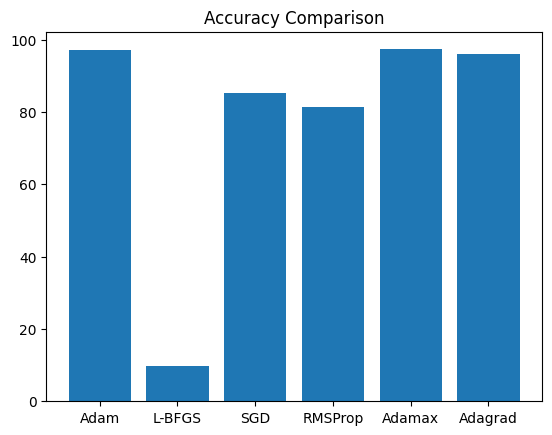

In [23]:
  import matplotlib.pyplot as plt

  plt.bar(results.keys(), [v["accuracy"] for v in results.values()])
  plt.title("Accuracy Comparison")

- **Графики времени обучения**:

Text(0.5, 1.0, 'Training time Comparison')

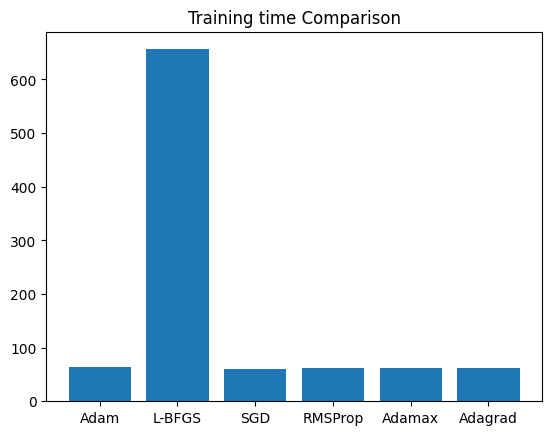

In [24]:
  plt.bar(results.keys(), [v["time"] for v in results.values()])
  plt.title("Training time Comparison")

- **Графики пямяти**:

Text(0.5, 1.0, 'Training RAM usage Comparison')

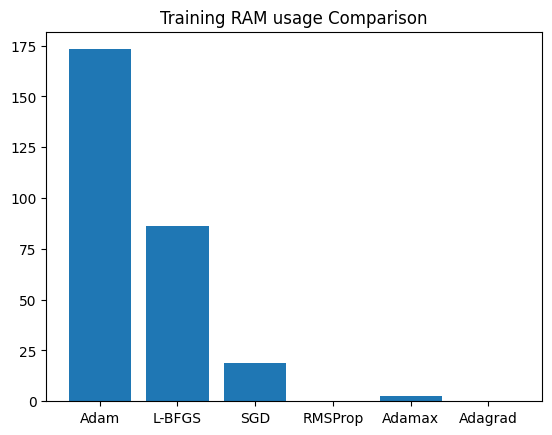

In [25]:
  plt.bar(results.keys(), [v["memory"] for v in results.values()])
  plt.title("Training RAM usage Comparison")

- **График потребления CPU**

Text(0.5, 1.0, 'Training CPU usage Comparison')

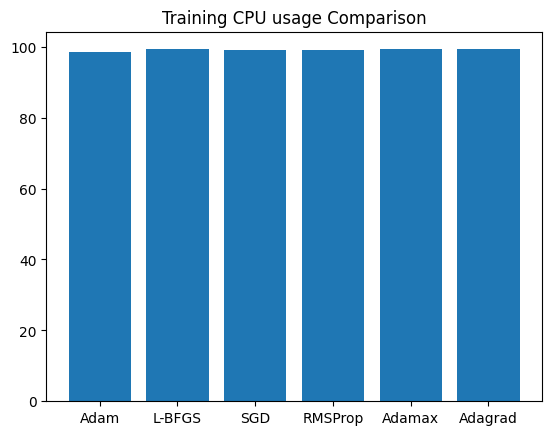

In [26]:
  plt.bar(results.keys(), [v["cpu"] for v in results.values()])
  plt.title("Training CPU usage Comparison")

---

#### **9. Анализ полученных результатов:**

#### **А. Математические основы методов**

**1. Связь с изученными методами**

- **Ближайший к Ньютона:**  
  **L-BFGS** — квази‑Ньютоновский метод, аппроксимирующий гессиан с помощью последних пар $s_k = x_{k+1} - x_k$, $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$, в отличие от **Adam**, который использует лишь информацию о первых двух моментах градиента ($m_t$ и $v_t$) для адаптивного шага без явной аппроксимации гессиана.

- **Адаптивный шаг в Adam:**  
  Адаптивность позволяет корректировать шаг для каждого параметра с учётом истории градиентов, что помогает стабилизировать обучение при различающихся масштабах и избегать проблем с выбором глобального шага.

- **Приближение гессиана и метод Ньютона:**  
  В L‑BFGS накопленные пары $(s_k, y_k)$ используются для рекурсивного обновления приближения обратного гессиана, что улучшает направление спуска.  
  Полный метод Ньютона редко применяют в глубоком обучении из-за большой вычислительной и памятьной сложности, а также из-за проблем с нестабильностью гессиана в не-выпуклых задачах.

**2. Алгоритмические особенности**

- **SGD vs полный градиентный спуск:**  
  - *Полный градиентный спуск* вычисляет точный градиент по всему датасету, что обеспечивает стабильность, но требует больших ресурсов.  
  - *SGD* использует один пример или мини-батч, что делает итерации быстрой, хотя и шумной, способствуя выходу из локальных минимумов.

- **Балансировка в L-BFGS:**  
  L‑BFGS сохраняет ограниченное число последних обновлений, чтобы учесть информацию о кривизне без расчёта полного гессиана, тем самым соединяя эффективность методов второго порядка с умеренными вычислительными затратами.


### **Б. Анализ скорости сходимости**

### 3. Графики потерь и точности

- **Почему Adam сходится быстрее, чем SGD, несмотря на стохастичность?**  
  Adam использует адаптивную корректировку шага через экспоненциальное сглаживание градиентов и их квадратов. Эта адаптация помогает компенсировать шум, характерный для стохастических оценок, и ускоряет сходимость на ранних этапах обучения.

- **Если L‑BFGS на первых итерациях сходился медленно, а затем резко улучшил результат, чем можно это объяснить?**  
  На начальных итерациях L‑BFGS начинает собирать информацию о направлении и кривизне (с помощью пар $s_k$ и $y_k$). После накопления достаточного числа таких пар аппроксимация обратного гессиана становится точнее, что резко улучшает качество шага и ускоряет сходимость.

### 4. Роль гиперпараметров

- **Влияние learning rate:**  
  - **С адаптивным шагом (Adam, RMSProp):**  
    $\alpha$ задаёт базовый масштаб, а адаптивные коэффициенты корректируют его для каждого параметра индивидуально. Это снижает чувствительность к точному подбору глобального шага, но всё равно требует разумного выбора.
  
  - **Без адаптивного шага (SGD, L‑BFGS):**  
    Learning rate напрямую определяет размер шага для всех параметров. Слишком большой $\alpha$ может привести к расходимости, а слишком маленький – к медленной сходимости, поэтому выбор параметра критичен.

- **Почему у L‑BFGS меньше эпох, но больше времени на эпоху?**  
  L‑BFGS использует более сложные вычисления (аккумуляция и обработка пар $(s_k, y_k)$ для аппроксимации кривизны), что требует больше вычислительных ресурсов на каждой итерации/эпохе. Однако за счёт качественного возвращаемого направления спуска модель быстрее сходится в плане числа эпох.

### **5. Связь с теорией нелинейных систем**

### 9. Интерпретация методов

- **Связь метода Ньютона с оптимизацией:**  
  Метод Ньютона для систем нелинейных уравнений ищет нули функции $f(x)$ по схеме  
  $
  x_{k+1}=x_k - J^{-1}(x_k) f(x_k)
  $
  где $J(x_k)$ — якобиан. При оптимизации мы ищем минимум функции, то есть точку, где $\nabla f(x)=0$. Таким образом, методы Ньютона (или их модификации) служат основу для методов второго порядка, применяемых в глубоком обучении.

- **Приближённый градиент в SGD:**  
  Для огромных датасетов вычисление полного градиента затратно, поэтому в SGD используется оценка на мини-батче. Это позволяет ускорить вычисления, хотя вводит шум в направление спуска, который зачастую помогает избежать плохих седловых точек, но требует грамотного подбора шага для устойчивости.

### 10. Проблемы реализации

- **Численные проблемы вычисления гессиана:**  
  Полный гессиан имеет размер $n \times n $, что в глубоких моделях приводит к огромным вычислительным затратам и проблемам с памятью. При приближении (например, в L‑BFGS) ошибки в вычислении разностей $s_k$ и $y_k$ могут привести к неустойчивым или не положительно определённым аппроксимациям.

- **Избежание "застревания" Adam:**  
  Adam использует экспоненциальные скользящие оценки первого $m_t$ и второго $v_t$ моментов градиента. Адаптивное масштабирование шага и стохастичность мини-батчей помогают смягчить влияние локальных минимумов, обеспечивая более гибкий обход "застреваний" и улучшая сходимость.

#### **10. Что ещё можно попробовать для этого набора данных?**
- Метод [forward gradient descent](https://github.com/orobix/fwdgrad).
- Оптимизаторы из других библиотек, например, [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), [TensorFlow / Keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).